## Robustness between donors

Compare DE effects predictions on different pairs of donors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


from copy import deepcopy
from tqdm import tqdm

import sys
sys.path.append('../../3_DE_analysis/')
from DE_analysis_utils import *

In [3]:
import yaml

# Load color palettes from yaml file
with open('../../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
results_dir = datadir + 'donor_robustness_analysis/'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [5]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil

In [6]:
de_counts = pd.read_csv(f'{datadir}/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

In [7]:
de_counts.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD
1,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD
2,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD
3,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD
4,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,0.000000,False,NaN,False,1 DE gene,no on-target KD


## Read donor robustness analysis outputs

From `get_donor_robustness_expanded_set.ipynb`

In [8]:
datadir = '/mnt/oak/users/emma/data/GWT/'
experiment_name = 'CD4i_final'
all_correlations = pd.read_csv('../results/DE_donor_robustness_correlation.csv', index_col=0)

In [9]:
all_correlations

,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,culture_condition,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000055070,CE0008678_CE0010866,CE0008162_CE0006864,0.637810,0.900497,14,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
1,ENSG00000055070,CE0008678_CE0008162,CE0010866_CE0006864,0.620045,0.889326,30,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
2,ENSG00000055070,CE0008678_CE0006864,CE0010866_CE0008162,0.680359,0.935248,17,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
3,ENSG00000101457,CE0008678_CE0010866,CE0008162_CE0006864,0.812467,0.900709,128,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD
4,ENSG00000101457,CE0008678_CE0008162,CE0010866_CE0006864,0.588123,0.855585,296,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ENSG00000196584,CE0008162_CE0008678,CE0006864_CE0010866,0.504285,0.759802,1216,Stim48hr,XRCC2,Stim48hr,73.0,337,178,515,-4.205363,True,25.721466,False,>10 DE genes,on-target KD
146,ENSG00000196584,CE0008162_CE0010866,CE0006864_CE0008678,0.474476,0.722692,1513,Stim48hr,XRCC2,Stim48hr,73.0,337,178,515,-4.205363,True,25.721466,False,>10 DE genes,on-target KD
147,ENSG00000197798,CE0008162_CE0006864,CE0008678_CE0010866,0.510533,0.846368,525,Stim48hr,FAM118B,Stim48hr,319.0,171,177,348,-3.596817,True,10.586093,False,>10 DE genes,on-target KD
148,ENSG00000197798,CE0008162_CE0008678,CE0006864_CE0010866,0.615843,0.830667,496,Stim48hr,FAM118B,Stim48hr,319.0,171,177,348,-3.596817,True,10.586093,False,>10 DE genes,on-target KD


In [10]:


# donor_robustness_corr = pd.read_csv('../results/DE_donor_robustness_correlation.csv', index_col=0)
donor_robustness_corr = all_correlations.copy()
donor_robustness_corr.head()
# Group by target and condition and compute t-test p-value for each group
grouped_pvals = donor_robustness_corr.groupby(['target_contrast', 'condition']).apply(
    lambda x: stats.ttest_1samp(x['correlation'].dropna().values, 0, alternative='greater')[1]
).reset_index(name='p_value').fillna(1)
# Apply Benjamini-Hochberg correction for multiple testing
grouped_pvals['bh_adjusted_pvalue'] = multipletests(grouped_pvals['p_value'].values, method='fdr_bh')[1]

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_2579516/3512323884.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  lambda x: stats.ttest_1samp(x['correlation'].dropna().values, 0, alternative='greater')[1]
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be

In [11]:
donor_correlation_summary = pd.read_csv('../results/DE_donor_robustness_correlation_summary.csv', index_col=0)
# add one-sided t-test pvals
donor_correlation_summary = pd.merge(donor_correlation_summary, grouped_pvals.sort_values('p_value'))
donor_correlation_summary['log10_pval'] = -np.log10(donor_correlation_summary['bh_adjusted_pvalue'])

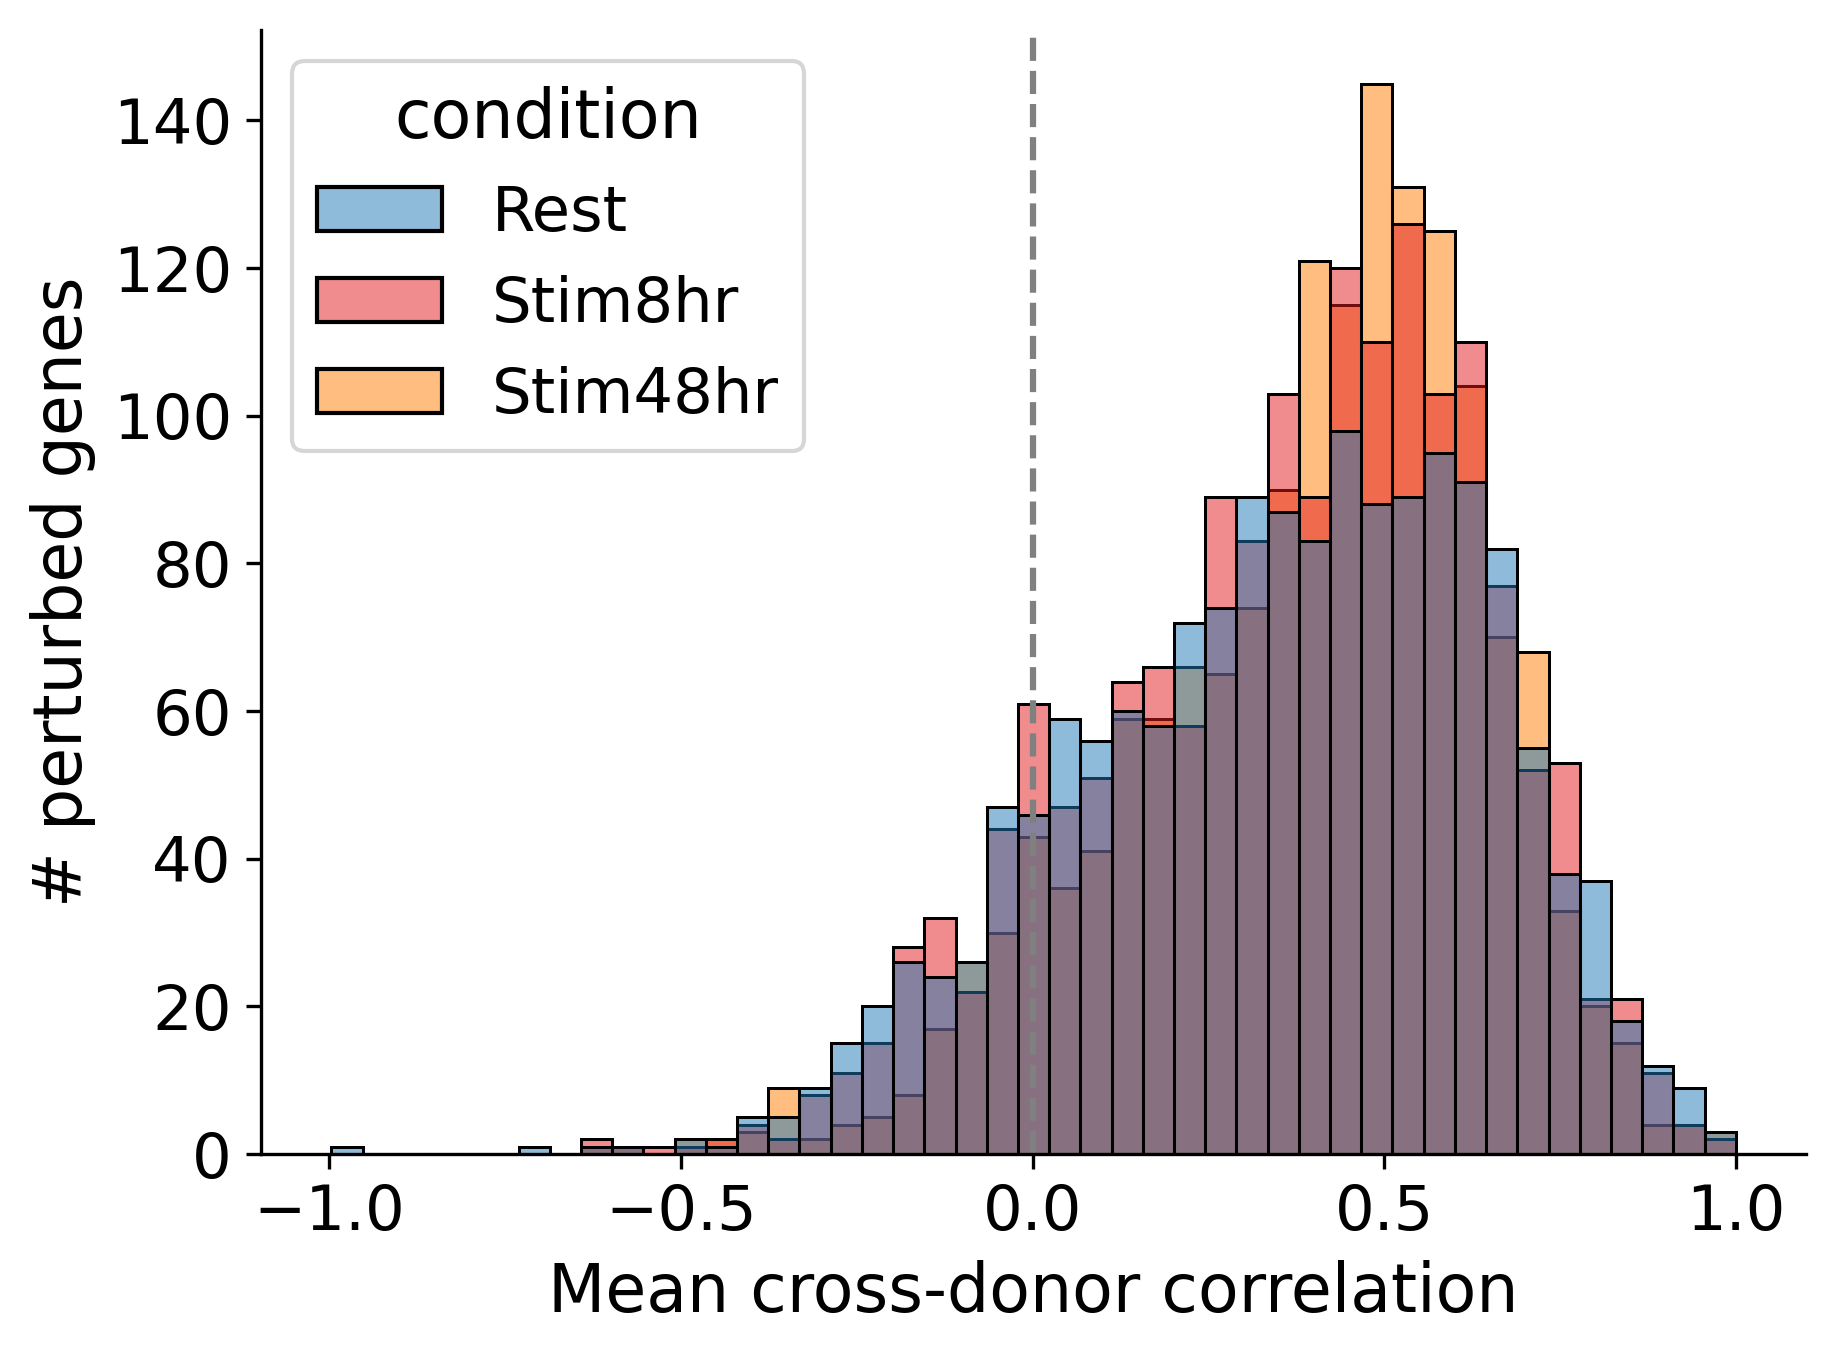

In [12]:
sns.histplot(data=donor_correlation_summary.reset_index(), x='donor_correlation_mean', hue='condition', alpha=0.5, palette=palettes['culture_condition'])
plt.axvline(x=0, linestyle='--', color='grey')
plt.xlabel('Mean cross-donor correlation');
plt.ylabel('# perturbed genes');
sns.despine()
plt.savefig('../results/donor_robustness.mean_corr_hist.pdf')
plt.savefig('../results/donor_robustness.mean_corr_hist.png')

In [13]:
donor_correlation_summary['donor_correlation_mean'].shape

(4880,)

In [14]:
all_correlations

,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,culture_condition,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000055070,CE0008678_CE0010866,CE0008162_CE0006864,0.637810,0.900497,14,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
1,ENSG00000055070,CE0008678_CE0008162,CE0010866_CE0006864,0.620045,0.889326,30,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
2,ENSG00000055070,CE0008678_CE0006864,CE0010866_CE0008162,0.680359,0.935248,17,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
3,ENSG00000101457,CE0008678_CE0010866,CE0008162_CE0006864,0.812467,0.900709,128,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD
4,ENSG00000101457,CE0008678_CE0008162,CE0010866_CE0006864,0.588123,0.855585,296,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ENSG00000196584,CE0008162_CE0008678,CE0006864_CE0010866,0.504285,0.759802,1216,Stim48hr,XRCC2,Stim48hr,73.0,337,178,515,-4.205363,True,25.721466,False,>10 DE genes,on-target KD
146,ENSG00000196584,CE0008162_CE0010866,CE0006864_CE0008678,0.474476,0.722692,1513,Stim48hr,XRCC2,Stim48hr,73.0,337,178,515,-4.205363,True,25.721466,False,>10 DE genes,on-target KD
147,ENSG00000197798,CE0008162_CE0006864,CE0008678_CE0010866,0.510533,0.846368,525,Stim48hr,FAM118B,Stim48hr,319.0,171,177,348,-3.596817,True,10.586093,False,>10 DE genes,on-target KD
148,ENSG00000197798,CE0008162_CE0008678,CE0006864_CE0010866,0.615843,0.830667,496,Stim48hr,FAM118B,Stim48hr,319.0,171,177,348,-3.596817,True,10.586093,False,>10 DE genes,on-target KD


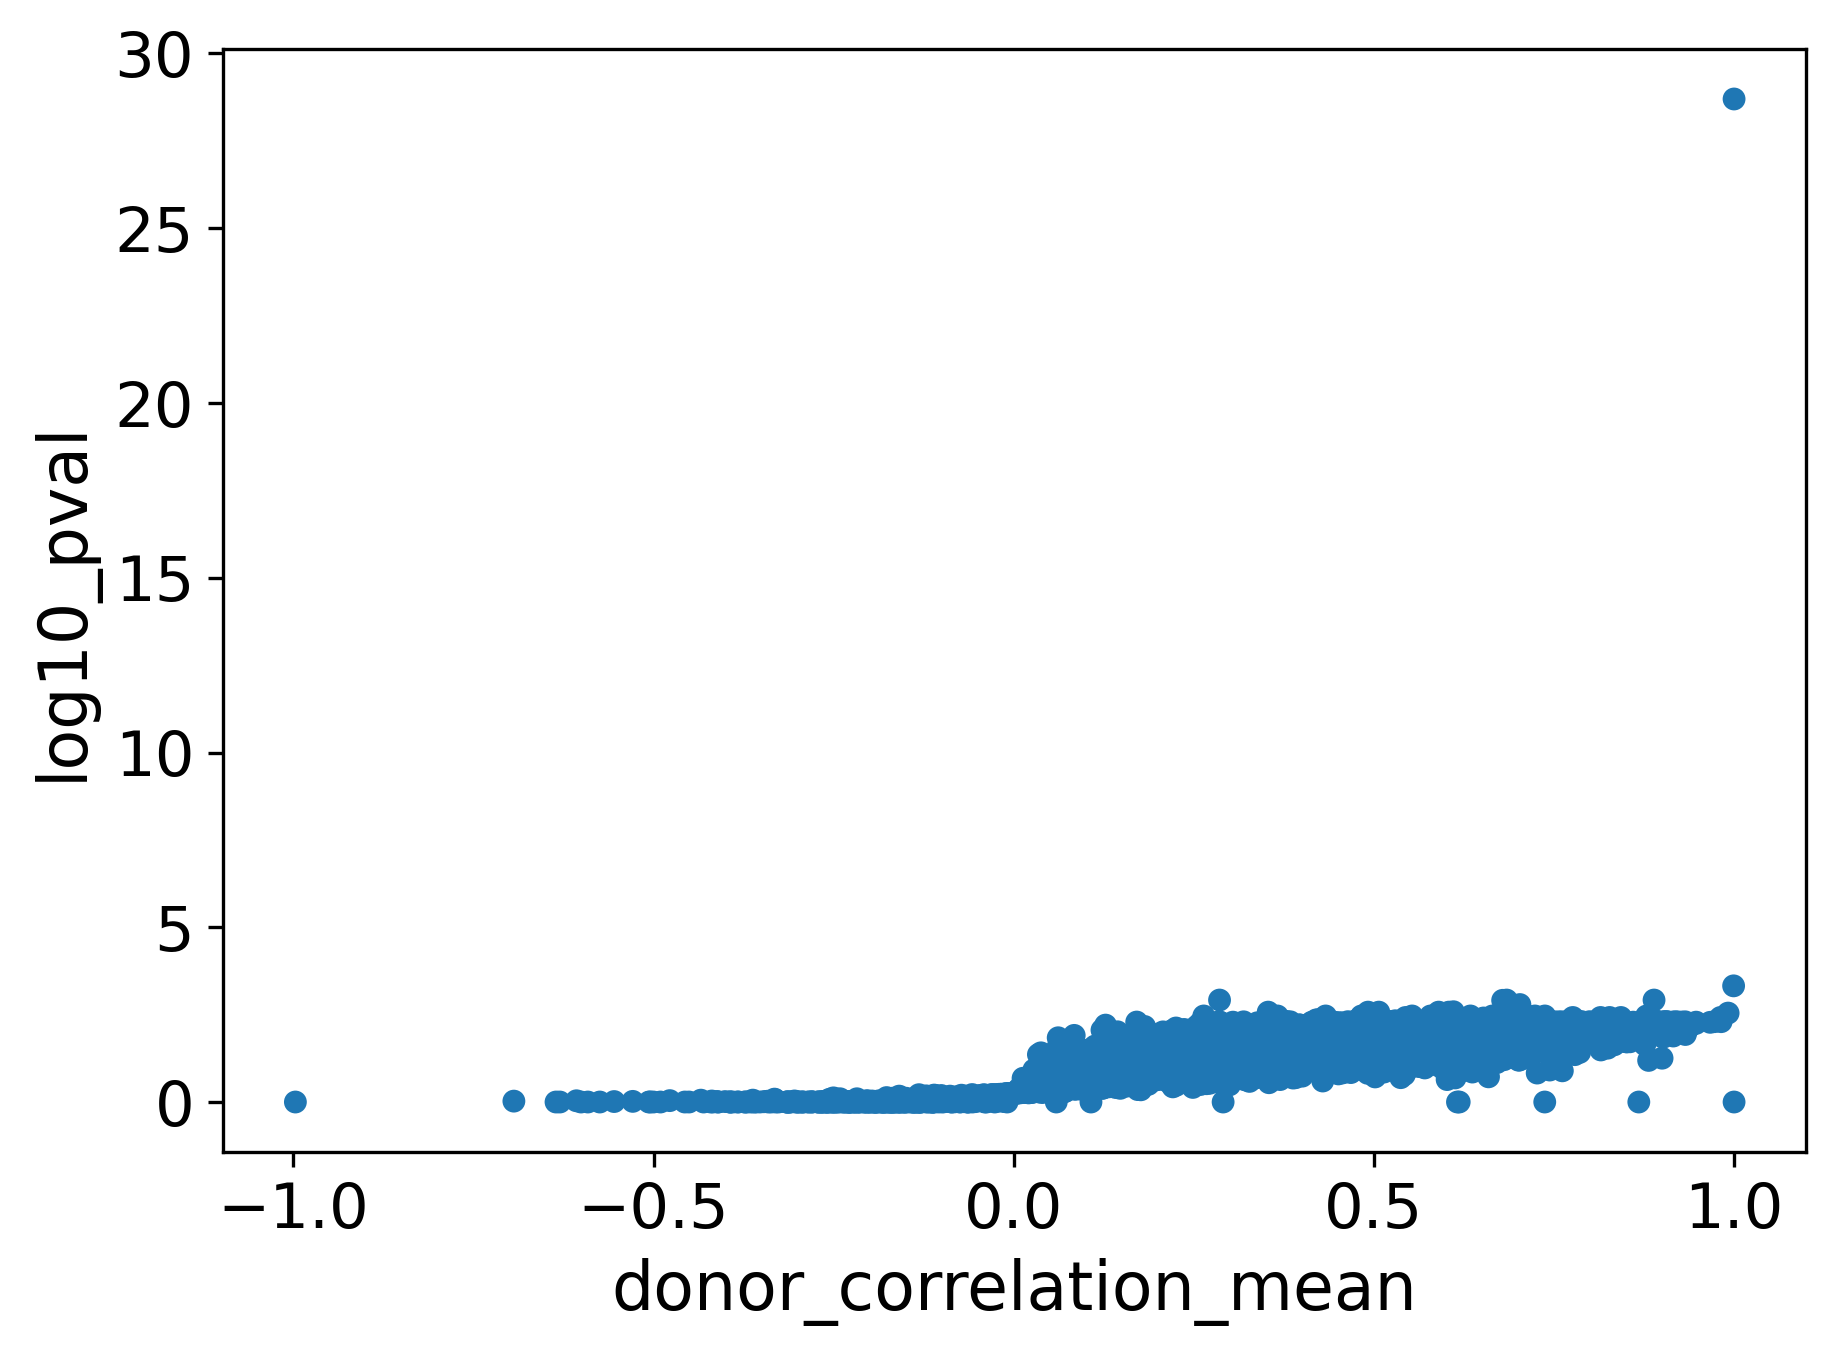

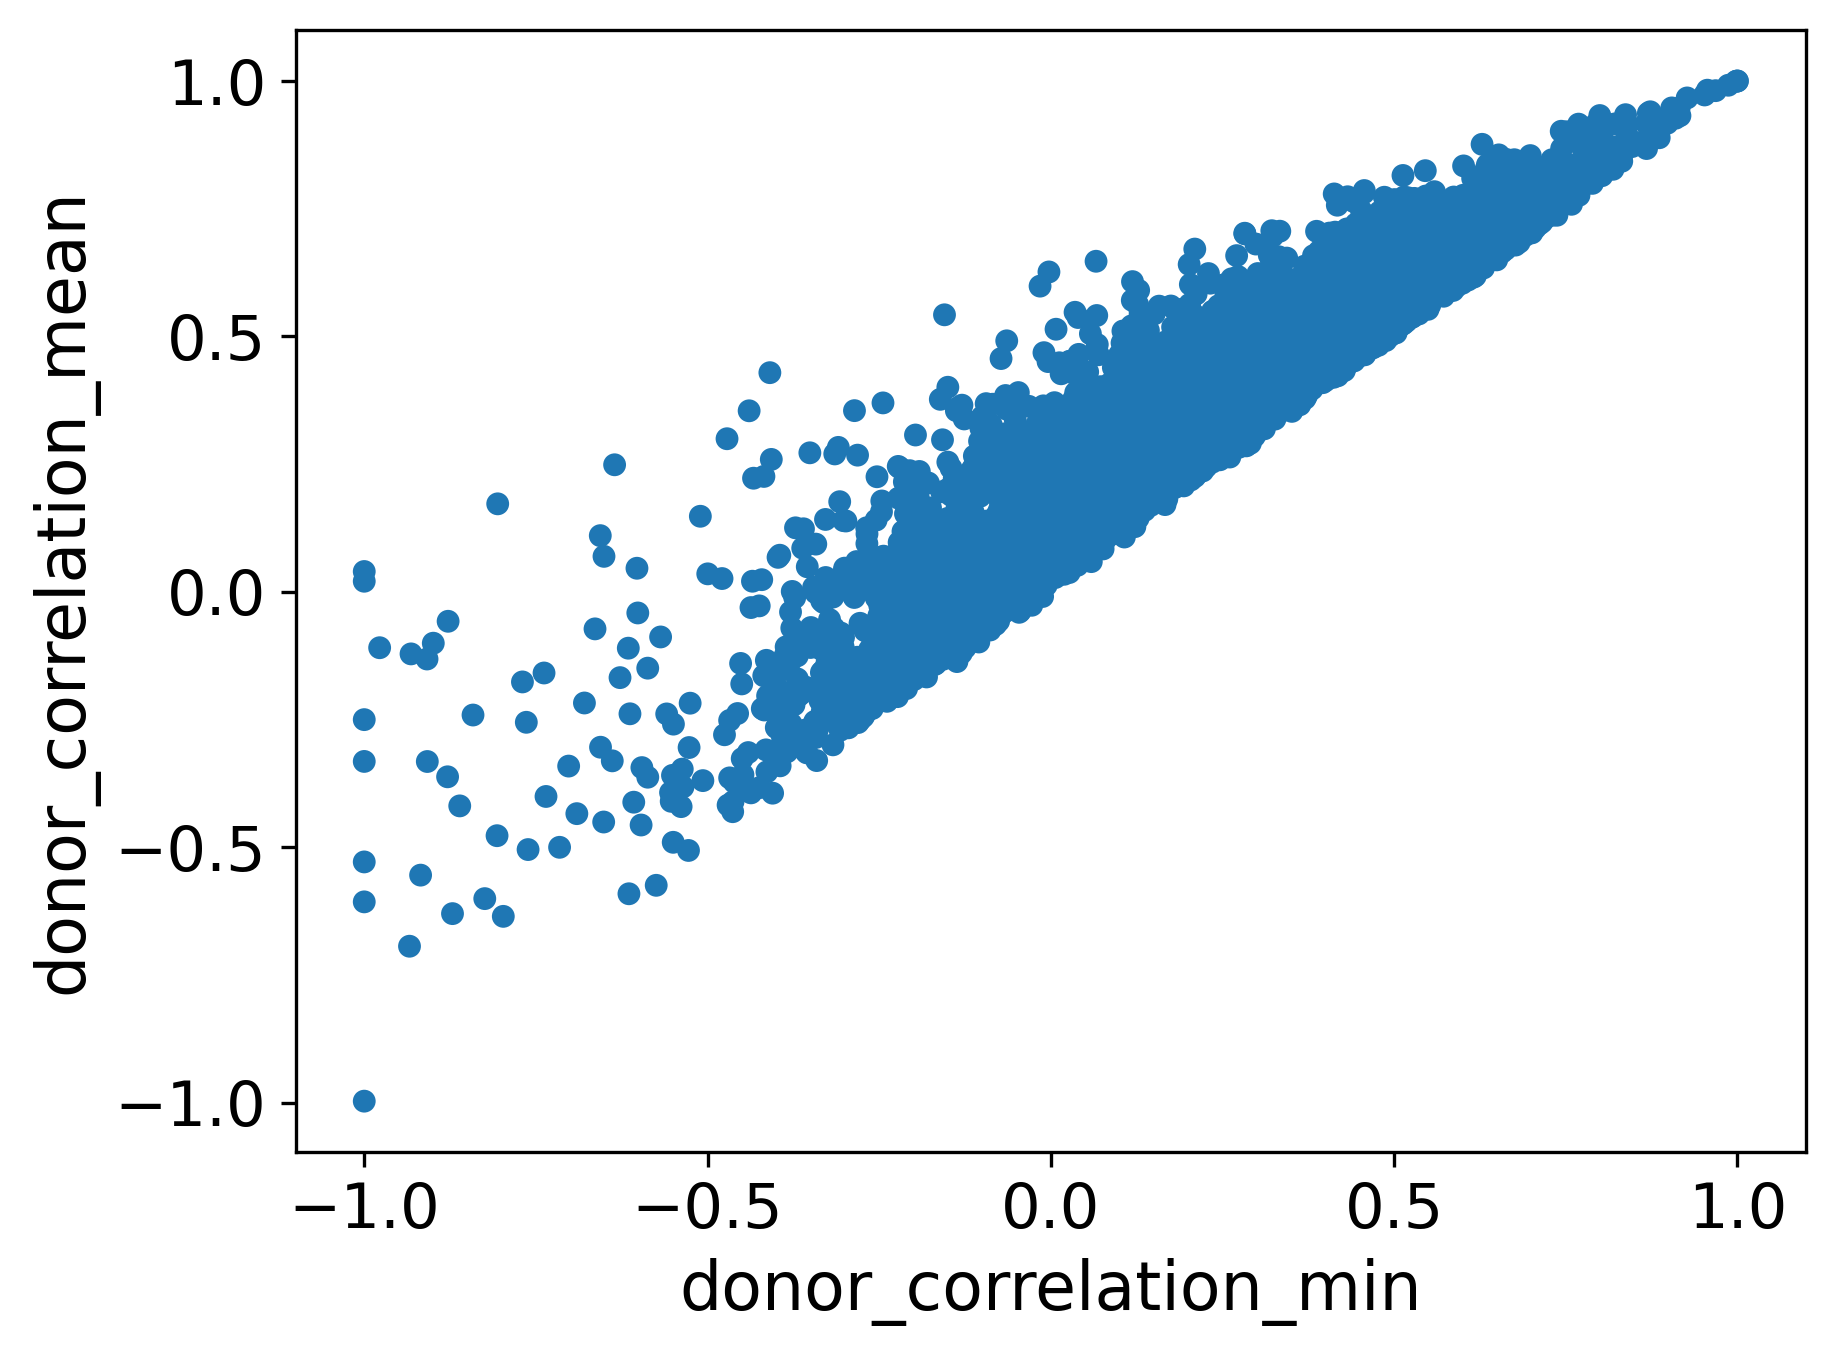

In [15]:
sns.scatterplot(data=donor_correlation_summary, x='donor_correlation_mean', y='log10_pval', edgecolor='none', s=30)
plt.show()
# Scatter plot with correlation coefficient
g = sns.scatterplot(data=donor_correlation_summary, x='donor_correlation_min', y='donor_correlation_mean', edgecolor='none', s=30)
# plt.xscale('log')

# # Calculate Pearson correlation coefficient
# corr_coef = donor_correlation_summary['n_cells_target'].corr(donor_correlation_summary['donor_correlation_mean'])
# plt.annotate(f'Correlation: {corr_coef:.3f}', 
#              xy=(0.05, 0.95), 
#              xycoords='axes fraction', 
#              fontsize=10, 
#              verticalalignment='top')

In [16]:
all_correlations.shape

(14640, 19)

In [17]:
all_correlations.groupby(['condition', 'target_contrast']).apply(lambda x: (x['correlation'] > 0).sum()).value_counts()

/tmp/ipykernel_2579516/3329418134.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_correlations.groupby(['condition', 'target_contrast']).apply(lambda x: (x['correlation'] > 0).sum()).value_counts()


3    3779
2     525
1     315
0     261
Name: count, dtype: int64

In [18]:
# Where the same perturbation is measured across conditions, are results consistent across donors in all conditions?
n_signif_conditions = donor_correlation_summary.pivot(columns='condition', index='target_contrast', values='donor_correlation_mean').dropna() > 0
n_signif_conditions.sum(1).value_counts()

3    718
2     60
0     28
1     22
Name: count, dtype: int64

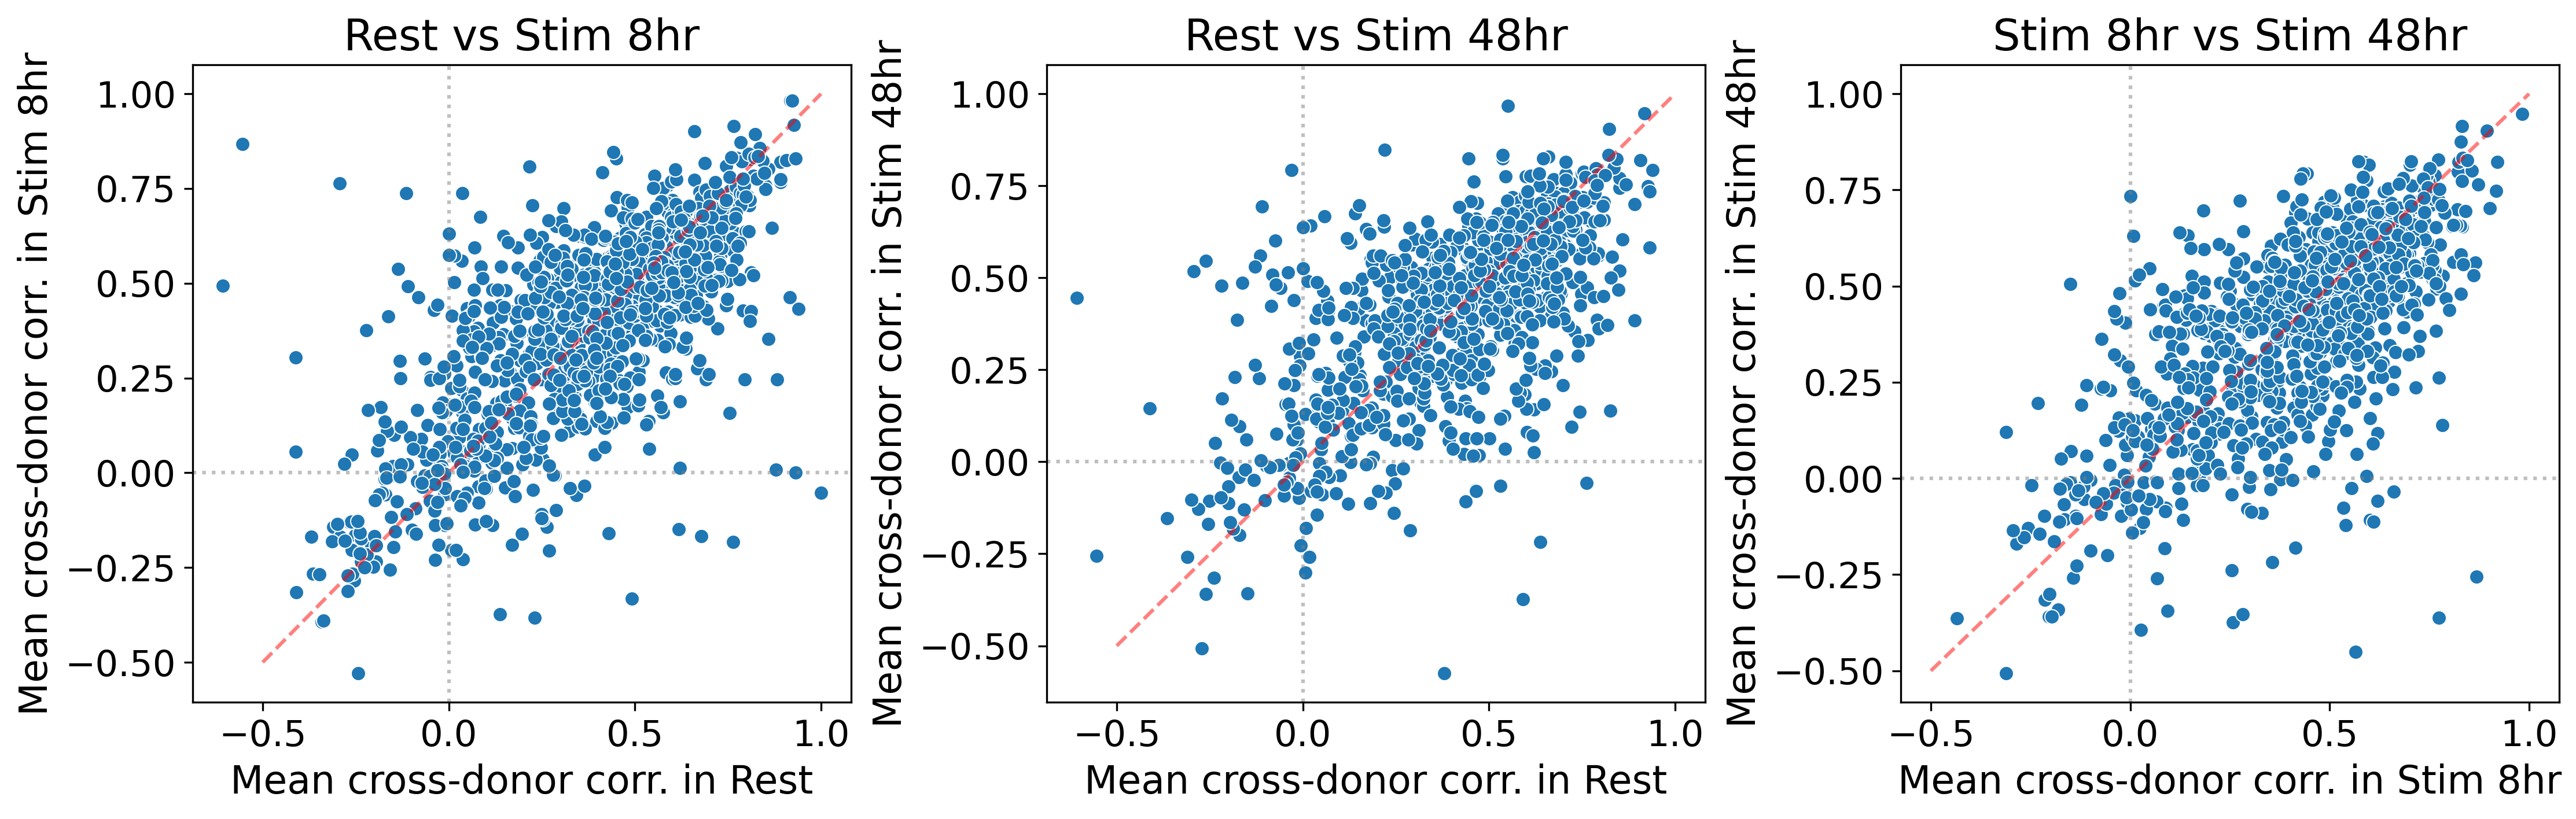

In [19]:
wide_corr = donor_correlation_summary.pivot(columns='condition', index='target_contrast', values='donor_correlation_mean')

# Create a figure with subplots to compare all 3 conditions
plt.figure(figsize=(15, 5))

# Rest vs Stim 8hr
plt.subplot(1, 3, 1)
sns.scatterplot(data=wide_corr, x='Rest', y='Stim8hr')
plt.xlabel('Mean cross-donor corr. in Rest')
plt.ylabel('Mean cross-donor corr. in Stim 8hr')
plt.title('Rest vs Stim 8hr')
plt.plot([-0.5, 1], [-0.5, 1], color='red', linestyle='--', alpha=0.5)  # Add diagonal line
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at 0
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)  # Add vertical line at 0

# Rest vs Stim 48hr
plt.subplot(1, 3, 2)
sns.scatterplot(data=wide_corr, x='Rest', y='Stim48hr')
plt.xlabel('Mean cross-donor corr. in Rest')
plt.ylabel('Mean cross-donor corr. in Stim 48hr')
plt.title('Rest vs Stim 48hr')
plt.plot([-0.5, 1], [-0.5, 1], color='red', linestyle='--', alpha=0.5)  # Add diagonal line
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at 0
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)  # Add vertical line at 0

# Stim 8hr vs Stim 48hr
plt.subplot(1, 3, 3)
sns.scatterplot(data=wide_corr, x='Stim8hr', y='Stim48hr')
plt.xlabel('Mean cross-donor corr. in Stim 8hr')
plt.ylabel('Mean cross-donor corr. in Stim 48hr')
plt.title('Stim 8hr vs Stim 48hr')
plt.plot([-0.5, 1], [-0.5, 1], color='red', linestyle='--', alpha=0.5)  # Add diagonal line
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at 0
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)  # Add vertical line at 0

plt.tight_layout()
plt.savefig('../results/donor_robustness.mean_corr_across_conditions.pdf')
plt.savefig('../results/donor_robustness.mean_corr_across_conditions.png')
plt.show()


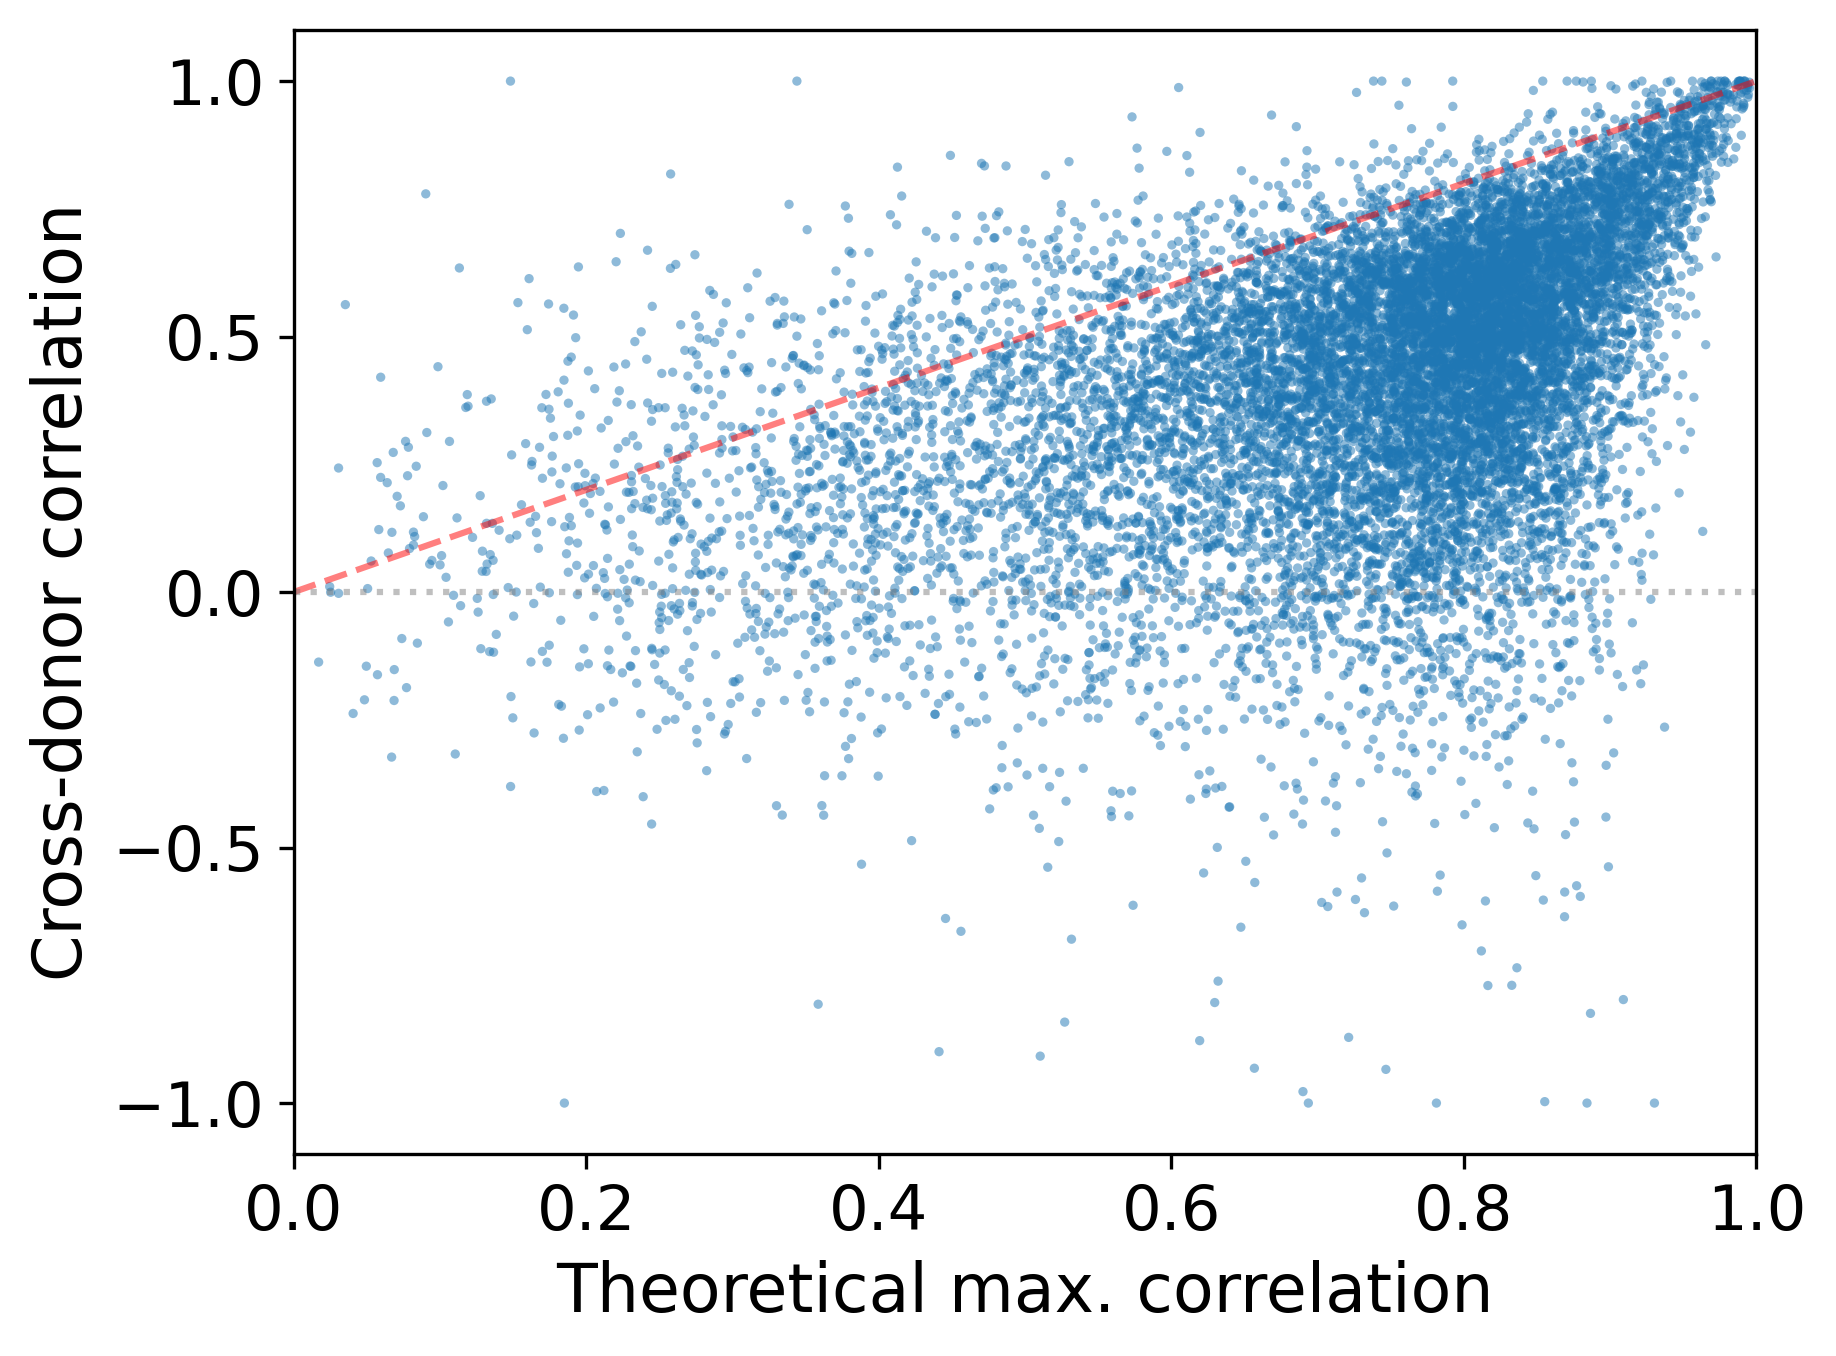

In [20]:
sns.scatterplot(data=all_correlations.reset_index(), x='correlation_ceiling', y='correlation', edgecolor='none', s=5, alpha=0.5)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.5)  # Add diagonal line
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at 0
plt.xlabel('Theoretical max. correlation')
plt.ylabel('Cross-donor correlation')
# plt.title('Correlation vs Correlation Ceiling')
plt.savefig('../results/donor_robustness.corr_vs_ceiling.pdf')
plt.savefig('../results/donor_robustness.corr_vs_ceiling.png')
plt.show()

In [21]:
all_correlations[(all_correlations['correlation_ceiling'] > 0.5) & (all_correlations['correlation'] < 0)].target_name.unique()

array(['ATP5F1B', 'AFG3L2', 'PRIMPOL', 'MIOS', 'GPR82', 'EME2', 'ZNF254',
       'MMP28', 'EP300', 'LRRC29', 'U2SURP', 'ZBTB39', 'SGK3', 'NMT1',
       'LRR1', 'HCN2', 'TBL1X', 'TMEM245', 'ZNF410', 'GAREM1', 'MAPRE3',
       'EFHC1', 'CMTM7', 'AIFM1', 'LMTK2', 'GNMT', 'FRA10AC1', 'ZNF618',
       'RPL29', 'ATP5ME', 'PTP4A2', 'OAF', 'CCDC137', 'SPTLC2', 'B3GAT2',
       'VARS2', 'TIAL1', 'ARL5B', 'C11orf54', 'ZNF627', 'PPP1R12A',
       'GOLGA3', 'FAM98C', 'KLF10', 'FAM161A', 'RNASEH1', 'EID2', 'OSGEP',
       'ILVBL', 'GALNT6', 'CNOT9', 'RPUSD1', 'LZTS1', 'ARMC8', 'ARID1A',
       'C1orf216', 'HPRT1', 'KRT72', 'CKS1B', 'HES4', 'PTPN1', 'DLG3',
       'CBX5', 'NDRG1', 'HIBADH', 'MRPS12', 'DMRTC2', 'ZCCHC24', 'GTF2H5',
       'ERF', 'SAP130', 'GCSH', 'NACC2', 'ZNF829', 'SIRT7', 'METRN',
       'ATP6V1E1', 'MRPS25', 'MORC2', 'NKX2-8', 'CHEK2', 'NOMO2', 'USP28',
       'MRPL10', 'MVD', 'CHMP4A', 'SLAMF7', 'LYRM2', 'ZPR1', 'ZNF589',
       'PSMB9', 'DOT1L', 'GNS', 'TMEM45B', 'CACHD1', 'UNCX

In [22]:
donor_correlation_summary[donor_correlation_summary.target_contrast.isin(n_signif_conditions[n_signif_conditions.sum(1) == 0].index)].target_name.unique()

array(['ARMC8', 'COPRS', 'DCAKD', 'EDC3', 'FBXL15', 'FHL1', 'HIST1H2BI',
       'HPS1', 'HSD17B13', 'HSDL2', 'IFFO2', 'IL12RB2', 'KLHDC10', 'LAT2',
       'LOXL4', 'NFKBIL1', 'NRAS', 'PIGB', 'PXMP4', 'RAB11FIP1', 'RAB27B',
       'RHEB', 'SLC5A6', 'SMAD3', 'TENT2', 'TNNC1', 'ZMAT1', 'ZNF613'],
      dtype=object)

### Spot check low correlations

In [23]:
combined_de_adata = anndata.read_h5ad(f'{datadir}/{experiment_name}/{experiment_name}.DE_donor_robustness.h5ad')
combined_de_adata.layers['zscore'] = combined_de_adata.layers['log_fc'] / combined_de_adata.layers['lfcSE']

In [24]:
combined_de_adata.obs['n_cells_target'] = 0 # to avoid warning

In [25]:
all_correlations.head()

,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,culture_condition,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000055070,CE0008678_CE0010866,CE0008162_CE0006864,0.637810,0.900497,14,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
1,ENSG00000055070,CE0008678_CE0008162,CE0010866_CE0006864,0.620045,0.889326,30,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
2,ENSG00000055070,CE0008678_CE0006864,CE0010866_CE0008162,0.680359,0.935248,17,Rest,SZRD1,Rest,574.0,12,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD
3,ENSG00000101457,CE0008678_CE0010866,CE0008162_CE0006864,0.812467,0.900709,128,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD
4,ENSG00000101457,CE0008678_CE0008162,CE0010866_CE0006864,0.588123,0.855585,296,Rest,DNTTIP1,Rest,1768.0,137,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD


In [26]:
combined_de_stats = get_de_stats(combined_de_adata, signif_col = 'adj_p_value', effect_col = 'log_fc')
combined_de_stats['donor_pair'] = combined_de_stats.index.str.split('_').str[2:].str.join('_')
# n_de_pairs = combined_de_stats.pivot(index = ['target_name', 'condition'], columns = 'donor_pair', values = 'n_total_de_genes').fillna(0)


pl_df = pd.merge(
    all_correlations,
    combined_de_stats[['target_name', 'condition', 'donor_pair', 'n_total_de_genes']].rename(columns={'donor_pair':'donors', 'n_total_de_genes':'n_total_de_genes_1'})
)
pl_df = pd.merge(
    pl_df,
    combined_de_stats[['target_name', 'condition', 'donor_pair', 'n_total_de_genes']].rename(columns={'donor_pair':'variable', 'n_total_de_genes':'n_total_de_genes_2'})
)

pl_df.head()

# pl_df = pl_df[pl_df['condition'] == 'Rest'].copy()

,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,culture_condition,target_name,condition,n_cells_target,...,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,n_total_de_genes_1,n_total_de_genes_2
0,ENSG00000055070,CE0008678_CE0010866,CE0008162_CE0006864,0.637810,0.900497,14,Rest,SZRD1,Rest,574.0,...,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD,9,3
1,ENSG00000055070,CE0008678_CE0008162,CE0010866_CE0006864,0.620045,0.889326,30,Rest,SZRD1,Rest,574.0,...,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD,5,10
2,ENSG00000055070,CE0008678_CE0006864,CE0010866_CE0008162,0.680359,0.935248,17,Rest,SZRD1,Rest,574.0,...,24,36,-18.275402,True,87.224226,False,>10 DE genes,on-target KD,8,6
3,ENSG00000101457,CE0008678_CE0010866,CE0008162_CE0006864,0.812467,0.900709,128,Rest,DNTTIP1,Rest,1768.0,...,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD,21,67
4,ENSG00000101457,CE0008678_CE0008162,CE0010866_CE0006864,0.588123,0.855585,296,Rest,DNTTIP1,Rest,1768.0,...,100,237,-24.027243,True,35.597792,False,>10 DE genes,on-target KD,136,22


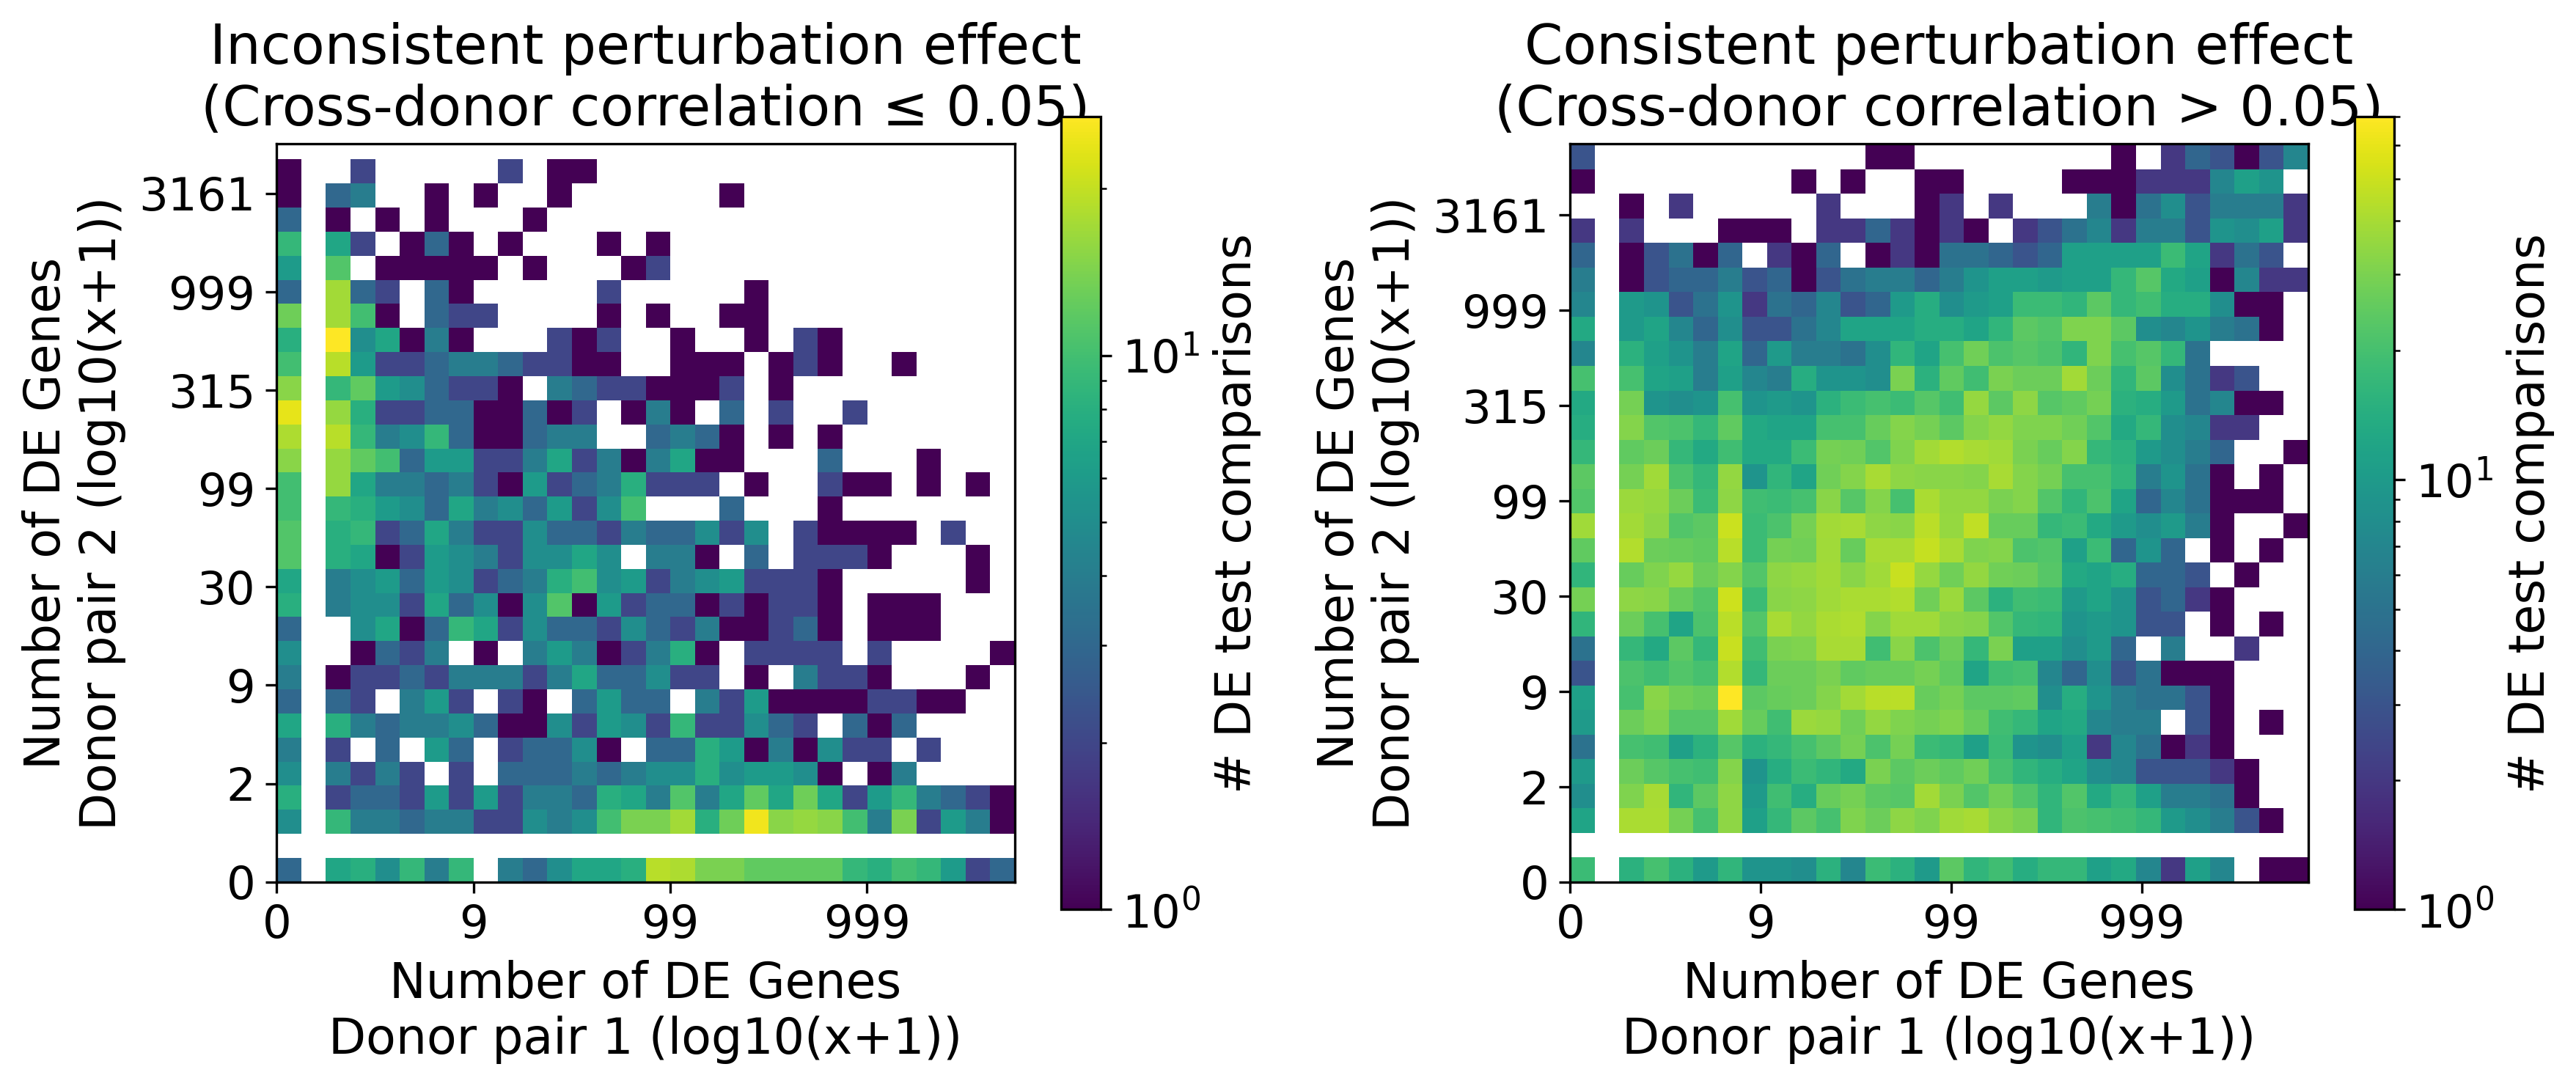

In [27]:
thresh = 0.05
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
h_low = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_total_de_genes_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_total_de_genes_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_low = plt.colorbar(h_low[3], label='# DE test comparisons')
cbar_low.ax.set_ylim(cbar_low.ax.get_ylim()[0], h_low[3].get_array().max())

plt.xlabel('Number of DE Genes\nDonor pair 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nDonor pair 2 (log10(x+1))')
plt.title(f'Inconsistent perturbation effect\n(Cross-donor correlation ≤ {thresh})')

# Add custom tick labels for original values
def log_ticks_formatter(x, pos):
    return str(int(np.power(10, x) - 1))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.subplot(1, 2, 2)
h_high = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_total_de_genes_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_total_de_genes_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_high = plt.colorbar(h_high[3], label='# DE test comparisons')
cbar_high.ax.set_ylim(cbar_high.ax.get_ylim()[0], h_high[3].get_array().max())

plt.xlabel('Number of DE Genes\nDonor pair 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nDonor pair 2 (log10(x+1))')
plt.title(f'Consistent perturbation effect\n(Cross-donor correlation > {thresh})')

# Add custom tick labels for original values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.tight_layout()
plt.savefig('../results/donor_robustness.n_de_genes_scatter.pdf')
plt.savefig('../results/donor_robustness.n_de_genes_scatter.png')

In [28]:
pl_df[(pl_df['correlation'] <= 0.05) & (pl_df['n_total_de_genes_1'] > 100) & (pl_df['n_total_de_genes_2'] > 100)]

,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,culture_condition,target_name,condition,n_cells_target,...,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,n_total_de_genes_1,n_total_de_genes_2
82,ENSG00000164654,CE0008678_CE0008162,CE0010866_CE0006864,-0.064092,0.641002,1511,Rest,MIOS,Rest,84.0,...,100,469,-3.742808,True,25.908417,False,>10 DE genes,on-target KD,457,426
155,ENSG00000033011,CE0008678_CE0006864,CE0010866_CE0008162,-0.031981,0.316350,1667,Rest,ALG1,Rest,72.0,...,27,133,-0.522661,False,23.776787,False,>10 DE genes,no on-target KD,732,130
709,ENSG00000163848,CE0008678_CE0008162,CE0010866_CE0006864,-0.042633,0.331235,4944,Rest,ZNF148,Rest,996.0,...,697,1355,-17.715670,True,52.840794,False,>10 DE genes,on-target KD,187,3378
867,ENSG00000169020,CE0008678_CE0010866,CE0008162_CE0006864,-0.103299,0.758965,1028,Rest,ATP5ME,Rest,234.0,...,86,365,-13.448202,True,84.019541,False,>10 DE genes,on-target KD,219,331
868,ENSG00000169020,CE0008678_CE0008162,CE0010866_CE0006864,0.027088,0.757267,990,Rest,ATP5ME,Rest,234.0,...,86,365,-13.448202,True,84.019541,False,>10 DE genes,on-target KD,232,311
967,ENSG00000137411,CE0008678_CE0008162,CE0010866_CE0006864,-0.062425,0.757000,612,Rest,VARS2,Rest,293.0,...,16,54,-5.510078,True,11.759732,False,>10 DE genes,on-target KD,102,145
1492,ENSG00000196396,CE0008678_CE0008162,CE0010866_CE0006864,-0.037408,0.653832,1684,Rest,PTPN1,Rest,143.0,...,30,384,-3.121682,True,99.667881,False,>10 DE genes,on-target KD,486,544
1493,ENSG00000196396,CE0008678_CE0006864,CE0010866_CE0008162,-0.003725,0.569918,1273,Rest,PTPN1,Rest,143.0,...,30,384,-3.121682,True,99.667881,False,>10 DE genes,on-target KD,358,405
1929,ENSG00000183765,CE0008678_CE0010866,CE0008162_CE0006864,-0.011496,0.531100,758,Rest,CHEK2,Rest,84.0,...,19,196,-4.301557,True,24.472162,False,>10 DE genes,on-target KD,170,171
1931,ENSG00000183765,CE0008678_CE0006864,CE0010866_CE0008162,-0.169852,0.658105,1924,Rest,CHEK2,Rest,84.0,...,19,196,-4.301557,True,24.472162,False,>10 DE genes,on-target KD,758,230


In [29]:
# signif_genes = de_long[de_long['adj_p_value'] < 0.01].gene.unique()
# other_genes = de_long[de_long['adj_p_value'] > 0.01].gene.unique()
# other_genes = np.random.choice(other_genes, len(signif_genes), replace=False)
# de_long_sig = de_long[de_long['gene'].isin(signif_genes)]


# plt.figure(figsize=(14, 6))
# de_long_sig_sorted_genes = de_long_sig.groupby('gene')['zscore'].mean().sort_values(ascending=False).reset_index()['gene']
# sns.pointplot(data=de_long_sig, x='gene', y='zscore', join=False, order=de_long_sig_sorted_genes, 
#                 label='all_effects',
#                 errorbar=("pi", 100), # show full range
#               linewidth=0.5, markersize=3)

# sns.pointplot(data=de_long_sig[de_long_sig['significant']], x='gene', y='zscore', join=False, order=de_long_sig_sorted_genes, 
#             label='significant_effects',
#                 errorbar=("pi", 100), # show full range
#               linewidth=2, markersize=3)
# plt.xticks([])
# # plt.title('Log Fold Change of Significant Genes')
# plt.xlabel(f'Significant genes (n = {len(signif_genes)})')
# plt.title(f'{t} KD in {cond} (Donor correlation = {np.round(mean_donor_corr, 2)})')
# plt.axhline(0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at 0
# plt.tight_layout()

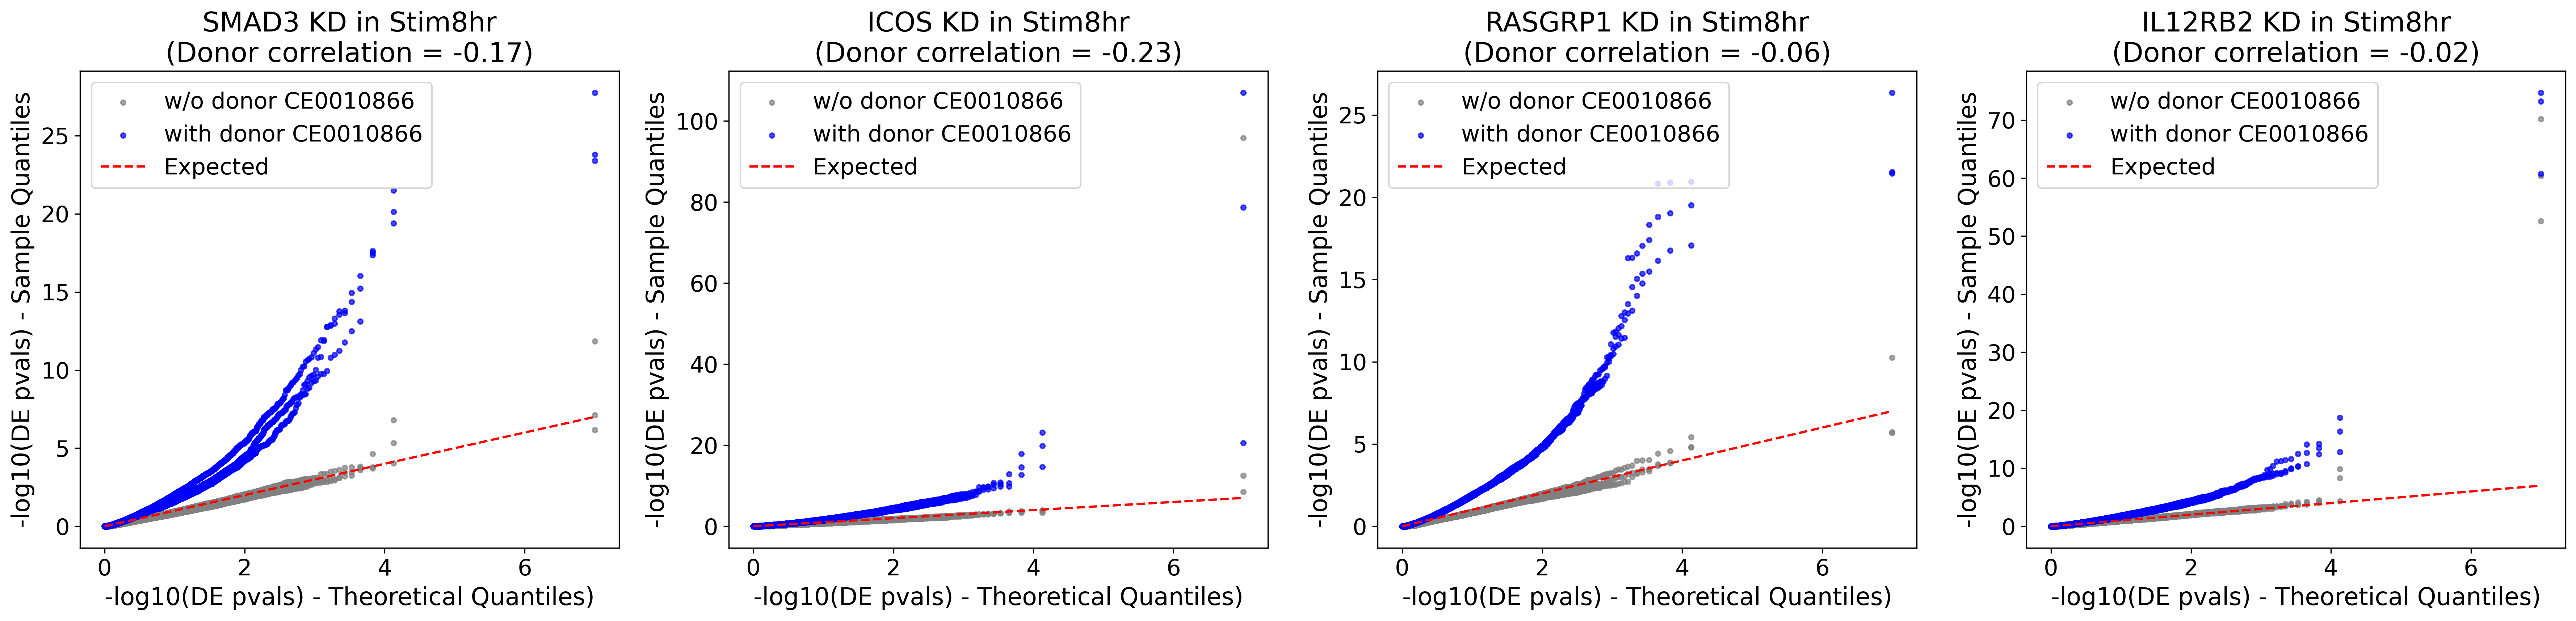

In [31]:
cond = 'Stim8hr'
targets = ['SMAD3', 'ICOS', 'RASGRP1', 'IL12RB2']

# Create a figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, t in enumerate(targets):
    de_long = get_DE_results_long(combined_de_adata, targets=[t], effect_estimates=['log_fc', 'zscore', 'p_value'], target_metadata_cols = ['culture_condition', 'donor_pair'] )
    de_long = de_long[de_long['culture_condition'] == cond]

    mean_donor_corr = donor_correlation_summary[(donor_correlation_summary.target_name == t) & (donor_correlation_summary.condition == cond)]['donor_correlation_mean'].iloc[0]

    # Prepare p-values for each donor pair
    donor_pairs = de_long['donor_pair'].unique()
    all_donors = np.unique(sum([x.split('_') for x in donor_pairs], []))
    d = 'CE0010866'

    ax = axes[i]
    # QQ plot of -log10 p-values
    for donor_pair in donor_pairs:
        p_values = de_long[de_long['donor_pair'] == donor_pair]['p_value']
        
        # Convert p-values to -log10 p-values
        p_values_sorted = np.sort(p_values)
        log_p_values = -np.log10(p_values_sorted)

        # Generate theoretical quantiles 
        theoretical_quantiles = np.linspace(0, 1, len(log_p_values))
        theoretical_log_quantiles = -np.log10(theoretical_quantiles+0.0000001)

        # Plot QQ plot -- rasterize the scatter points
        if d in donor_pair:
            ax.scatter(theoretical_log_quantiles, log_p_values, alpha=0.7, s=10, label=f'with donor {d}', color='blue', rasterized=True)
        else:
            ax.scatter(theoretical_log_quantiles, log_p_values, alpha=0.7, s=10, label=f'w/o donor {d}', color='grey', rasterized=True)

    # Add diagonal reference line
    ax.plot([0, max(theoretical_log_quantiles)], [0, max(theoretical_log_quantiles)], 
            color='red', linestyle='--', label='Expected')

    ax.set_xlabel('-log10(DE pvals) - Theoretical Quantiles)')
    ax.set_ylabel('-log10(DE pvals) - Sample Quantiles')
    ax.set_title(f'{t} KD in {cond}\n(Donor correlation = {np.round(mean_donor_corr, 2)})')

    # Modify legend to show only one representative entry for each category
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels)

plt.tight_layout()
plt.savefig('../results/donor_robustness.th17_example.pdf')
plt.savefig('../results/donor_robustness.th17_example.png')
plt.show()